In [34]:
%config InlineBackend.figure_format = 'svg'
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
from tqdm import tqdm_notebook as tqdm
import pandas as pd

from utils import *
from sparse_gplvm import free_energy, get_predictive_variational_gp, gp_log_prob, fit_inducing_points, fit_latents

DATA_DIR = "../data/gplvm/"
IMG_FOLDER = "../images/sparse_gplvm/"

In [35]:
latent_dim = 2

# oil dataset
Y = pd.read_csv(DATA_DIR + '/train_data.txt', header=None, sep='\s+').values[:, :]
labels = (pd.read_csv(DATA_DIR + '/labels.txt', header=None, sep='\s+').values[:, :]).astype(np.int)

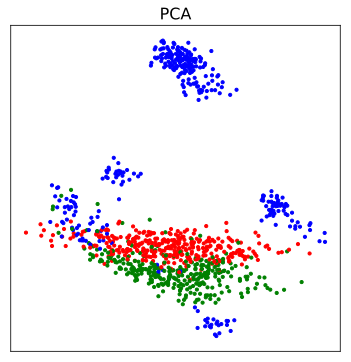

In [38]:
plt.figure(figsize = (13, 6))
plt.subplot(121)
pca = PCA(n_components=latent_dim)
X_pca = pca.fit_transform(Y)
X_pca = X_pca
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])
plt.title('PCA', fontsize=16)
plt.xticks([])
plt.yticks([])

plt.show()

To do:
- Get loss: log lik + regularisation
- Derivatives of loss wrt X_n, X_m, hyperparams

In [39]:
def rbf(X, sigma_f, length_scale, noise_coef=0.):

    
    num_points = X.shape[0]

    cov = np.dot(X, X.T)
    diag = np.diag(cov)

    # (x_n - x_m)' (x_n - x_m) = x_n'x_n + x_m'x_m - 2x_n'x_m
    cov_ = diag.reshape((num_points, 1)) + diag.reshape((1, num_points)) - 2 * cov

    return (sigma_f ** 2.) * np.exp(-1. / (2 * length_scale ** 2.) * cov_) + noise_coef * np.eye(num_points)

def rbf_cross_terms(A, B, sigma_f, length_scale, noise_coef=0.):
    """
    A - N x H matrix
    B - M x H matrix
    """
    
    n = A.shape[0]
    m = B.shape[0]
    
    A_grid = np.swapaxes(np.tile(A, reps=(m, 1, 1)), 0, 1)
    B_grid = np.tile(B, reps=(n, 1, 1))
    
    return sigma_f**2 * np.exp(-1. / (2. * length_scale**2) * np.sum((A_grid - B_grid)**2, axis=-1))

In [40]:
def free_energy(X_n, X_m, Y, sigma_noise, sigma_f, length_scale, verbose=False):
    """
    Free energy of a sparse variational GP. If the output is vector-valued, then
    the individual dimensions are assumed to be independent. 

    X_m          - M x H matrix: M inducing points of dimension H
    X_n          - N x H matrix: N input data points of dimension H
    Y            - N x D matrix: N output data points of dimension D
    sigma_noise  - scalar: assumed measurement noise on each output dimension
    sigma_f      - scalar: scale factor of RBF kernel
    length_scale - scalar: length scale of RBF kernel

    RBF kernel:

    k(x_i, x_j) = sigma_f^2 * exp( -1. / (2 * length_scale^2) * (x_i - x_j)'(x_i - x_j))

    """
    # ======================================================================
    # Ensure the input has the correct size
    # ======================================================================
    if len(X_m.shape) != 2:
        raise IncompatibleShapeError(
            "X_m rank of shape must be 2 not: {}".format(len(X_m.shape)))

    if len(X_n.shape) != 2:
        raise IncompatibleShapeError(
            "X_n rank of shape must be 2 not: {}".format(len(X_n.shape)))

    if len(Y.shape) != 2:
        raise IncompatibleShapeError(
            "Y rank of shape must be 2 not: {}".format(len(Y.shape)))

    m, h = X_m.shape
    n, d = Y.shape
    n_, h_ = X_n.shape

    if h != h_:
        raise IncompatibleShapeError(
            "X_m and X_n must share the same 2nd dimension: {} and {} must match".format(h, h_))

    if n != n_:
        raise IncompatibleShapeError(
            "Y and X_n must share the same 1nd dimension: {} and {} must match".format(n, n_))

    # ======================================================================
    # Do stuff
    # ======================================================================

    K = rbf(np.concatenate((X_n, X_m), axis=0), sigma_f, length_scale, noise_coef=sigma_noise**2)
    
    K_nn = K[:n, :n]
    K_mm = K[n:, n:]
    K_nm = K[:n, n:]
    K_mm_inv = np.linalg.inv(K_mm + 1e-6 * np.eye(K_mm.shape[0]))

    noise_cov_diag = (sigma_noise ** 2.) * np.ones(n)
    noise_cov = (sigma_noise ** 2.) * np.eye(n)

    gp_cov = np.dot(np.dot(K_nm, K_mm_inv), K_nm.T)
    log_det_gp_cov, _ = fast_matrix_slogdet(noise_cov_diag, K_nm, K_nm.T, K_mm)
    gp_QF = fast_quadratic_form(noise_cov_diag, K_nm, K_nm.T, K_mm, Y)

    log_prob_gaussian = -n / 2. * np.log(2 * np.pi) \
                        -0.5 * log_det_gp_cov \
                        -0.5 * np.trace(gp_QF)

    regularising_term = float(d) / (2 * sigma_noise ** 2.) * (np.trace(K_nn) - np.trace(gp_cov))

    if verbose:
        print("\n==================")
        print("Noise Covariance Det: \t{}: ".format(np.linalg.slogdet(noise_cov)[0]))
        print("K inverse Det: \t\t{}".format(np.linalg.det(K_mm_inv)))
        print("GP covariance Det: \t{}".format(log_det_gp_cov))
        print("Quadratic Form Trace: \t{}".format(np.trace(gp_QF)))
        print("Regularising Term: \t{}".format(regularising_term))
        print("Log probability: \t{}".format(log_prob_gaussian))
        print("\n==================")

    return log_prob_gaussian - regularising_term


def fast_free_energy(X_n, X_m, Y, sigma_noise, sigma_f, length_scale, epsilon=1e-6, verbose=False):
    """
    Free energy of a sparse variational GP. If the output is vector-valued, then
    the individual dimensions are assumed to be independent. 

    X_m          - M x H matrix: M inducing points of dimension H
    X_n          - N x H matrix: N input data points of dimension H
    Y            - N x D matrix: N output data points of dimension D
    sigma_noise  - scalar: assumed measurement noise on each output dimension
    sigma_f      - scalar: scale factor of RBF kernel
    length_scale - scalar: length scale of RBF kernel

    RBF kernel:

    k(x_i, x_j) = sigma_f^2 * exp( -1. / (2 * length_scale^2) * (x_i - x_j)'(x_i - x_j))

    """
    
    # ======================================================================
    # Ensure the input has the correct size
    # ======================================================================
    if len(X_m.shape) != 2:
        raise IncompatibleShapeError(
            "X_m rank of shape must be 2 not: {}".format(len(X_m.shape)))

    if len(X_n.shape) != 2:
        raise IncompatibleShapeError(
            "X_n rank of shape must be 2 not: {}".format(len(X_n.shape)))

    if len(Y.shape) != 2:
        raise IncompatibleShapeError(
            "Y rank of shape must be 2 not: {}".format(len(Y.shape)))

    m, h = X_m.shape
    n, d = Y.shape
    n_, h_ = X_n.shape

    if h != h_:
        raise IncompatibleShapeError(
            "X_m and X_n must share the same 2nd dimension: {} and {} must match".format(h, h_))

    if n != n_:
        raise IncompatibleShapeError(
            "Y and X_n must share the same 1nd dimension: {} and {} must match".format(n, n_))

    # ======================================================================
    # Do stuff
    # ======================================================================
    
    # Calculate required covariance matrices in O(nm^2)
    K_mm = rbf(X_m, sigma_f, length_scale, noise_coef=sigma_noise**2)
    K_nm = rbf_cross_terms(X_n, X_m, sigma_f, length_scale)
    K_mm_inv = np.linalg.inv(K_mm + epsilon * np.eye(K_mm.shape[0]))
    
    K_nn_trace = n * (sigma_f**2 + sigma_noise**2)
    
    noise_cov_diag = (sigma_noise ** 2.) * np.ones(n)
    
    # This is O(nm^2)
    gp_cov = np.dot(np.dot(K_nm, K_mm_inv), K_nm.T)
    log_det_gp_cov, _ = fast_matrix_slogdet(noise_cov_diag, K_nm, K_nm.T, K_mm)
    gp_QF = fast_quadratic_form(noise_cov_diag, K_nm, K_nm.T, K_mm, Y)

    log_prob_gaussian = -n / 2. * np.log(2 * np.pi) \
                        -0.5 * log_det_gp_cov \
                        -0.5 * np.trace(gp_QF)

    regularising_term = float(d) / (2 * sigma_noise ** 2.) * (K_nn_trace - np.trace(gp_cov))

    return log_prob_gaussian - regularising_term

In [41]:
def fit_params(X_n, 
               X_m, 
               Y, 
               learn_rates,
               log_sigma_noise=1., 
               log_sigma_f=0., 
               log_length_scale=-1., 
               num_iter=5000, 
               early_stopping=1e-3, 
               verbose=True, 
               log_every=100):

    F_lambda = lambda X_n_, X_m_, log_sigma_noise_, log_sigma_f_, log_length_scale_: \
                   free_energy(X_n_, 
                               X_m_, 
                               Y, 
                               np.exp(log_sigma_noise_), 
                               np.exp(log_sigma_f_), 
                               np.exp(log_length_scale_), 
                               verbose=verbose)

    theta = [X_n, X_m, log_sigma_noise, log_sigma_f, log_length_scale]
    dF_dtheta = [grad(F_lambda, i) for i in range(len(theta))]

    # Keep track of the loss
    prev_F = F_lambda(*theta)

    for i in range(num_iter):

        grads = [dF_dtheta[j](*theta) for j in range(len(theta))]
        theta = [theta[j] + learn_rates[j] * gradient for j, gradient in enumerate(grads)]

        current_F = F_lambda(*theta)
        
#         print(theta[0][0, :])
#         print(grads[0][0, :])
#         print("-")

        if abs(prev_F - current_F) <= early_stopping:
            print("Early convergence at iteration {}!".format(i))
            return tuple(theta)
        else:
            prev_F = current_F
            yield tuple(theta)

In [42]:
def fit(Y, 
        latent_dim, 
        labels,
        num_inducing_points,
        learn_rates=(1e-3, 1e-3, 1e-5, 1e-5, 1e-5),
        log_sigma_noise=0., 
        log_sigma_f=0., 
        log_length_scale=-1.,
        num_iter=3,
        verbose=True, 
        initialization="random_uniform",
        log_every=100):
    
    if len(learn_rates) != 5:
        raise Exception("Learn rates must be of length 5!")
    
    # Step 1: Initial guess for X and X_m
    pca = PCA(n_components=latent_dim)
    X_n = pca.fit_transform(Y)
    
    n, h = X_n.shape
    
    # Random initialisation of inducing points
    
    if initialization == "on_X":
        # In this strategy we uniformly assign each inducing
        # point to an actual data point
        indices = np.random.choice(a=len(X_n),
                                   size=num_inducing_points,
                                   replace=False)

        X_m = X_n[indices, :]
    
    elif initialization == "random_uniform":
        
        X_m = np.random.uniform(low=-2, high=2, size=(num_inducing_points, h))
    
    # TODO: implement other initialisation strategies
    
    # Shorthands
    log_sn = log_sigma_noise
    log_sf = log_sigma_f
    log_ls = log_length_scale
        
    # Step 2: Optimise X_m and model parameters
    for i, (X_n, X_m, log_sn, log_sf, log_ls) in tqdm(enumerate(fit_params(X_n=X_n,
                                                                           X_m=X_m, 
                                                                           Y=Y,
                                                                           log_sigma_noise=log_sn,
                                                                           log_sigma_f=log_sf, 
                                                                           log_length_scale=log_ls, 
                                                                           learn_rates=learn_rates,
                                                                           num_iter=num_iter,
                                                                           verbose=False)), 
                                                                         total=num_iter):

        sigma_noise = np.exp(log_sn)
        sigma_f = np.exp(log_sf)
        length_scale = np.exp(log_ls)

        if i % log_every == 0:

            free_en = fast_free_energy(X_n, 
                                       X_m, 
                                       Y, 
                                       sigma_noise, 
                                       sigma_f, 
                                       length_scale)
            print('Iteration:', i + 1, 
                  'sigma_noise: %.3f, sigma_f: %.3f, length_scale: %.3f, free_energy: %.3f'
                   % (sigma_noise, sigma_f, length_scale, free_en))

            plt.scatter(X_n[:, 0], X_n[:, 1], s=10, alpha=0.3, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])
            plt.scatter(X_m[:, 0], X_m[:, 1], s=25, alpha=0.5, c='k', marker='x')
            plt.show()
            
    return X_n, X_m, sigma_noise, sigma_f, length_scale

/Users/gergelyflamich/Documents/sbrml/gaussian_processes/gp_venv/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration: 1 sigma_noise: 0.482, sigma_f: 0.980, length_scale: 0.439, free_energy: -7959.748


Iteration: 26 sigma_noise: 0.368, sigma_f: 1.050, length_scale: 0.682, free_energy: -6889.015


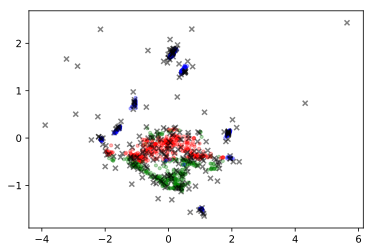

Iteration: 51 sigma_noise: 0.328, sigma_f: 1.138, length_scale: 0.736, free_energy: -6797.732


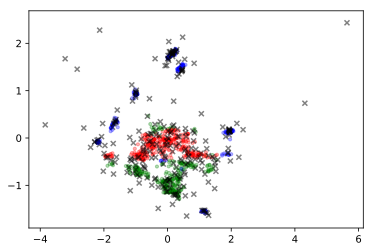

Iteration: 76 sigma_noise: 0.315, sigma_f: 1.222, length_scale: 0.774, free_energy: -6752.200


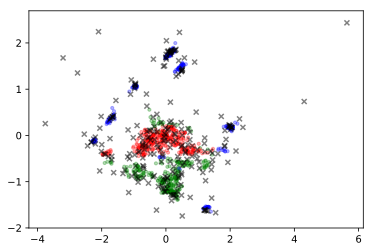

Iteration: 101 sigma_noise: 0.304, sigma_f: 1.303, length_scale: 0.813, free_energy: -6703.622


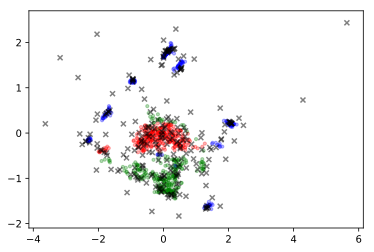

Iteration: 126 sigma_noise: 0.294, sigma_f: 1.383, length_scale: 0.858, free_energy: -6648.094


Iteration: 151 sigma_noise: 0.291, sigma_f: 1.462, length_scale: 0.887, free_energy: -6611.503


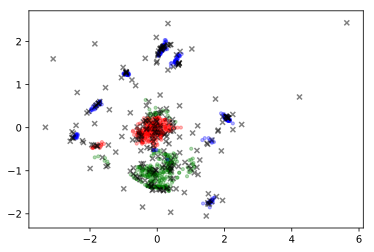

Iteration: 176 sigma_noise: 0.292, sigma_f: 1.541, length_scale: 0.887, free_energy: -6620.203


Iteration: 201 sigma_noise: 0.291, sigma_f: 1.616, length_scale: 0.896, free_energy: -6612.494


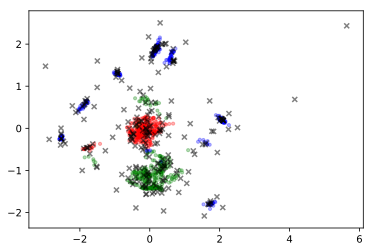

Iteration: 226 sigma_noise: 0.289, sigma_f: 1.689, length_scale: 0.921, free_energy: -6596.338


Iteration: 251 sigma_noise: 0.287, sigma_f: 1.764, length_scale: 0.941, free_energy: -6583.575


Iteration: 276 sigma_noise: 0.287, sigma_f: 1.839, length_scale: 0.967, free_energy: -6575.521


Iteration: 301 sigma_noise: 0.285, sigma_f: 1.914, length_scale: 1.001, free_energy: -6567.795


Iteration: 326 sigma_noise: 0.283, sigma_f: 1.989, length_scale: 1.042, free_energy: -6560.983


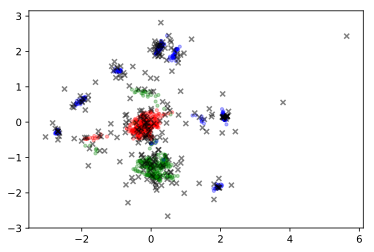

Iteration: 351 sigma_noise: 0.283, sigma_f: 2.066, length_scale: 1.092, free_energy: -6563.610


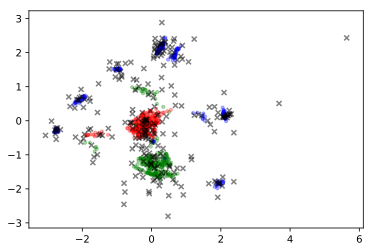

Iteration: 376 sigma_noise: 0.283, sigma_f: 2.146, length_scale: 1.158, free_energy: -6573.887


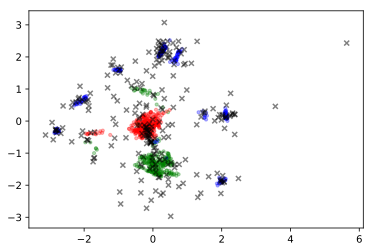

Iteration: 401 sigma_noise: 0.285, sigma_f: 2.233, length_scale: 1.233, free_energy: -6597.046


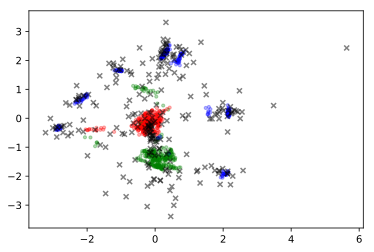

Iteration: 426 sigma_noise: 0.285, sigma_f: 2.326, length_scale: 1.331, free_energy: -6615.469


Iteration: 451 sigma_noise: 0.290, sigma_f: 2.430, length_scale: 1.451, free_energy: -6657.699


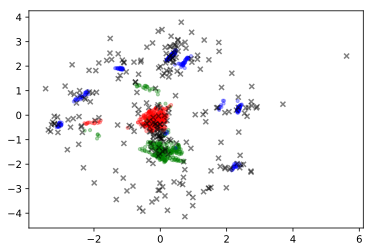

Iteration: 476 sigma_noise: 0.290, sigma_f: 2.546, length_scale: 1.573, free_energy: -6655.769


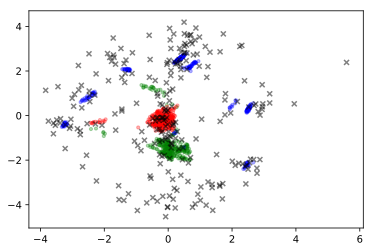

In [ ]:
# Set seed for reproducibility
np.random.seed(40)


X, X_m, sigma_noise, sigma_f, length_scale = fit(Y, 
                                                 latent_dim, 
                                                 labels,
                                                 num_inducing_points=250,
                                                 log_sigma_noise=-1.,
                                                 num_iter=500, 
                                                 initialization="on_X",
                                                 learn_rates=(1e-2, 1e-2, 1e-4, 3e-5, 1e-4), 
                                                 log_every=25,
                                                 verbose=False)

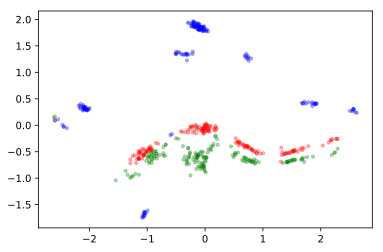

In [31]:
plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.3, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])

No handles with labels found to put in legend.


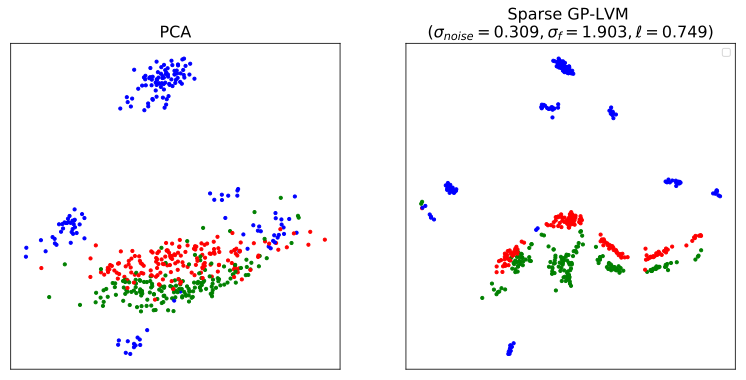

In [33]:
plt.figure(figsize = (13, 6))
plt.subplot(121)
pca = PCA(n_components=latent_dim)
X_pca = pca.fit_transform(Y)
X_pca = X_pca
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])
plt.title('PCA', fontsize=16)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], s=10, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])
plt.title('Sparse GP-LVM \n($\\sigma_{{noise}} = {:.3f}, \\sigma_f = {:.3f}, \\ell = {:.3f}$)'.format(sigma_noise, 
                                                                      sigma_f, 
                                                                      length_scale), fontsize=16)
#plt.scatter(X_m[:, 0], X_m[:, 1], s=25, c='k', marker='x', label="Inducing Points")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.savefig(IMG_FOLDER +'/sparse_clustered.png')
plt.show()